In [1]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

In [2]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1

In [3]:
## Select a color for each team
# https://teamcolorcodes.com/nba-team-color-codes/
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
color_teams = ['#E03A3E', '#007A33', '#860038', '#0C2340', '#CE1141',
               '#00538C', '#0E2240', '#1D428A', '#BA0C2F', '#1D428A', '#FDB927',
               '#DB3EB1', '#EEE1C6', '#236192', '#000000', '#F58426', '#0077C0',
               '#002D62', '#ED174C', '#B95915', '#E03A3E', '#5A2D81', '#C4CED4',
               '#007AC1', '#B4975A', '#00471B', '#5D76A9', '#002B5C', '#1D42BA', '#00788C']
team_to_color = {}
i = 0
for t in list_teams:
    team_to_color.update({t: color_teams[i]})
    i += 1

In [12]:
from nba_api.stats.endpoints import teamgamelog

## List of tuples in this format: (game_id, is_home, opponent, is_win)
def build_games_for_team(team):
    gpbp = teamgamelog.TeamGameLog(team_id=team_to_id[team], headers=headers)
    tgl = gpbp.get_data_frames()[0]
    game_ids = tgl['Game_ID'].values
    games = []
    matchups = tgl['MATCHUP'].values
    results = tgl['WL'].values
    for i in range(len(matchups)):
        curr = matchups[i]
        is_home = True
        if '@' in curr:
            is_home = False
        opponent = curr[-3:]
        win = False
        if results[i] == 'W':
            win = True
        games.append((game_ids[i], is_home, opponent, win))
    return games

In [18]:
from nba_api.stats.endpoints import playbyplay
from nba_api.stats.library import eventmsgtype

def compare_matchup(game, event, team):
    gpbp = playbyplay.PlayByPlay(game_id=game[0], headers=headers)
    playByPlay = gpbp.get_data_frames()[0]
    home, visitor = get_home_and_away_event(event.value, playByPlay)
    ## If its a home game for the team
    if game[1]:
        plot_game_fgs(event, (team, team_to_color[team], home), (game[2], team_to_color[game[2]], visitor), game[3])
    else:
        plot_game_fgs(event, (game[2], team_to_color[game[2]], home), (team, team_to_color[team], visitor), game[3])
        

In [19]:
def get_home_and_away_event(event, pbp_game):
    home_team = []
    visitor_team = []
    for i in range(4):
        ## HAve it as fieldgoalmade bc tested with that field, can compare others too
        fieldgoalmade = pbp_game.loc[(pbp_game['EVENTMSGTYPE'] == event) & (pbp_game['PERIOD'] == i+1)]
        home = fieldgoalmade.loc[~(fieldgoalmade['HOMEDESCRIPTION'].values == None)]
        visitor= fieldgoalmade.loc[~(fieldgoalmade['VISITORDESCRIPTION'].values == None)]
        home_team.append(home.shape[0])
        visitor_team.append(visitor.shape[0])
    return home_team, visitor_team

In [21]:
def plot_game_fgs(stat_compare, ht, vt, result):
    N = 4
    ind = np.arange(N)  # the x locations for the groups
    width = 0.27       # the width of the bars

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    rects1 = ax.bar(ind, ht[2], width, color=ht[1])
    rects2 = ax.bar(ind+width, vt[2], width, color=vt[1])

    ax.set_ylabel(stat_compare)
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels( ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4') )
    ax.legend( (rects1[0], rects2[0]), (ht[0], vt[0]) )
    if result:
        title = 'In a WIN'
    else:
        title = 'uh oh its a LOSS'    
    ax.set_title(title)
    plt.show()

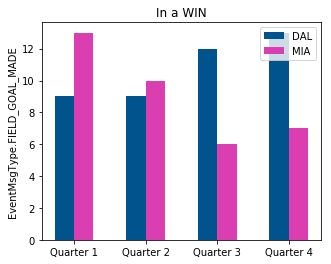

In [22]:
team = 'MIA'
games = build_games_for_team(team)
compare_matchup(games[3], eventmsgtype.EventMsgType.FIELD_GOAL_MADE, team)

In [11]:
gpbp = teamgamelog.TeamGameLog(team_id=team_to_id[team], headers=headers)
tgl = gpbp.get_data_frames()[0]
tgl.head()

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612748,0021900424,"DEC 20, 2019",MIA vs. NYK,W,21,8,0.724,240,43,...,0.735,9,42,51,34,6,3,17,22,129
1,1610612748,0021900410,"DEC 18, 2019",MIA @ PHI,W,20,8,0.714,240,40,...,0.800,11,36,47,26,6,4,12,14,108
2,1610612748,0021900397,"DEC 16, 2019",MIA @ MEM,L,19,8,0.704,240,37,...,0.839,7,28,35,22,9,7,14,26,111
3,1610612748,0021900384,"DEC 14, 2019",MIA @ DAL,W,19,7,0.731,265,39,...,0.824,5,44,49,27,8,3,8,18,122
4,1610612748,0021900374,"DEC 13, 2019",MIA vs. LAL,L,18,7,0.720,240,39,...,0.786,5,29,34,24,8,2,8,21,110
